In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import tqdm
import seaborn as sns
from sklearn.metrics import mean_squared_error

### Data

In [2]:
tetragonal = pd.read_csv('data/tetragonal.csv')
tetragonal = tetragonal[tetragonal.Zr > 0]

monoclinic = pd.read_csv('data/monoclinic.csv')
monoclinic = monoclinic[monoclinic.Zr > 0]

In [3]:
inputs = ['T']
features = ['en_p', 'ea', 'valence', 'pettifor', 'rad_ionic', 'rad_slater', 'rad_clementi']
outputs = ['a']

#### Stats

In [4]:
elements = ['Ce', 'Ti', 'Hf', 'Sn', 'Ge', 'Y', 'Sc', 'Yb', 'Er', 'Sm', 'Nd', 'Gd',
       'La', 'In', 'Nb', 'Ta', 'Zr']

In [5]:
tetr = tetragonal[
    np.bitwise_and(
        np.abs(tetragonal['T'] - 25) < 5,
        tetragonal['Ce'] > 0
    )
][['Ce', 'Zr', 'a', 'c']]

mono = monoclinic[
    np.bitwise_and(
        np.abs(monoclinic['T'] - 25) < 5,
        monoclinic['Ce'] > 0
    )
][['Ce', 'Zr', 'a', 'b', 'c', 'beta']]

In [6]:
def get_stats(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rsq, _ = stats.pearsonr(y_true, y_pred)
    
    return rmse, rsq

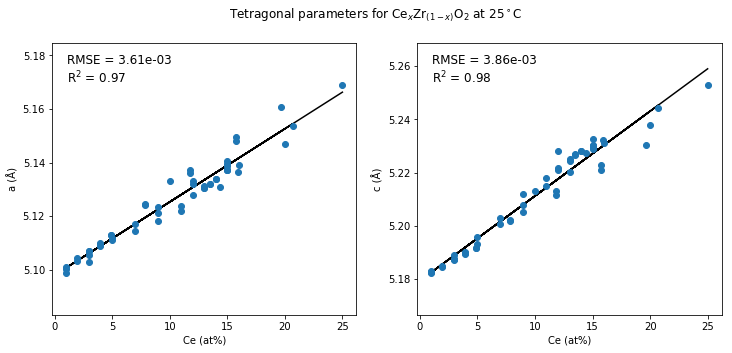

In [7]:
fig, ax_fig = plt.subplots(1, 2, figsize=(12, 5))

df = tetr
for output, ax in zip(['a', 'c'], ax_fig):
    
    ax.scatter(df.Ce, df[output])
    
    regression = stats.linregress(df.Ce, df[output])
    predict = lambda x: regression.intercept + regression.slope * x
    ax.plot(df.Ce, predict(df.Ce), 'k', zorder=-1)
    
    rmse, rsq = get_stats(df[output], predict(df.Ce))
    
    ax.set_xlabel('Ce (at%)')
    ax.set_ylabel('%s (Å)' % output)

    ax.annotate(
        'RMSE = %.2e \nR$^2$ = %.2f' % (rmse, rsq),
        (0.05, 0.96),
        xycoords='axes fraction',
        va='top',
        fontsize=12
    )

fig.suptitle('Tetragonal parameters for Ce$_x$Zr$_{(1-x)}$O$_2$ at 25$^\circ$C')
plt.show()

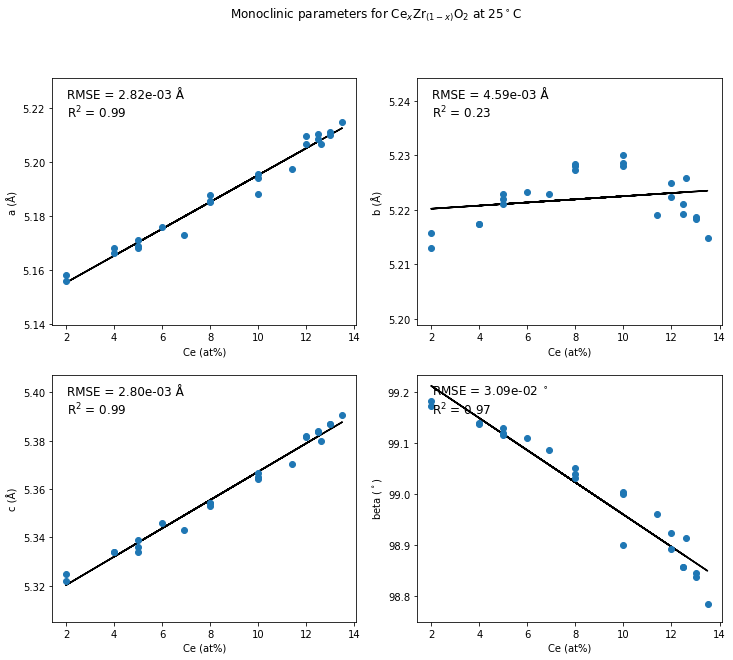

In [8]:
fig, ax_fig = plt.subplots(2, 2, figsize=(12, 10))

df = mono
for output, ax in zip(['a', 'b', 'c', 'beta'], ax_fig.reshape(-1)):
    ax.scatter(df.Ce, df[output])
    
    regression = stats.linregress(df.Ce, df[output])
    predict = lambda x: regression.intercept + regression.slope * x
    ax.plot(df.Ce, predict(df.Ce), 'k', zorder=-1)
    
    rmse, rsq = get_stats(df[output], predict(df.Ce))
    
    unit = '$^\circ$' if output == 'beta' else 'Å'
    
    ax.set_xlabel('Ce (at%)')
    ax.set_ylabel('%s (%s)' % (output, unit))

    ax.annotate(
        'RMSE = %.2e %s\nR$^2$ = %.2f' % (rmse, unit, rsq),
        (0.05, 0.96),
        xycoords='axes fraction',
        va='top',
        fontsize=12
    )

fig.suptitle('Monoclinic parameters for Ce$_x$Zr$_{(1-x)}$O$_2$ at 25$^\circ$C')
plt.show()

In [9]:
uncertainty_tetr = pd.Series({'a': 3.61e-3, 'c': 3.86e-3})
uncertainty_mono = pd.Series({'a': 2.82e-3, 'b': 4.59e-3, 'c': 2.80e-3, 'beta': 3.09e-2})

### Example from the paper with uncertainty

In [10]:
from cofactor.features import Features
from cofactor.model import LatticePredictor
from cofactor.calculator import CofactorCalculator, Lattice

In [11]:
featgen = Features.from_excel('data/elemental.xlsx')
model = LatticePredictor.from_file('models/model.pkl')
data = pd.read_csv('data/lattices.csv', index_col=0)

In [12]:
example_eddie = np.array([
    [11.393534002229654, 470.7213578500707],
    [12.508361204013376, 348.5148514851487],
    [12.909698996655514, 300.9900990099011],
    [13.444816053511701, 178.78359264497885],
    [13.846153846153847, 20.367751060820638],
])

cofactors_eddie = np.array([
    [12.497816164285508, 0.9977867711289287],
    [13.000483412177577, 0.9981617632840819],
    [13.498258868069184, 0.9990191227680352]
])

In [13]:
inputs = {
    'Ce': example_eddie[:, 0].reshape(-1, 1) / 100,
    'Zr': 1 - example_eddie[:, 0].reshape(-1, 1) / 100,
    'T': example_eddie[:, 1].reshape(-1, 1)
}
X = featgen.get_features(inputs, model.features)

/miniconda3/envs/dskoda/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


#### Computing and adding the error bar

In [18]:
uncertain_lambda2 = []

for _ in range(200):
    cofactors = []
    for tetr, mono in model.predict_lattice(X[model.features]):
        
        a = tetr.a + uncertainty_tetr.a * np.random.randn(1).item()
        c = tetr.c + uncertainty_tetr.c * np.random.randn(1).item()
        noisy_tetr = Lattice(a, a, c, 90)
        
        noisy_mono = Lattice(
            mono.a + uncertainty_mono.a * np.random.randn(1).item(),
            mono.b + uncertainty_mono.b * np.random.randn(1).item(),
            mono.c + uncertainty_mono.c * np.random.randn(1).item(),
            mono.beta + uncertainty_mono.beta * np.random.randn(1).item()
        )
        
        calc = CofactorCalculator(noisy_tetr, noisy_mono)
        cofactors.append(calc.get_cofactors())
    results = pd.concat([X, pd.DataFrame(cofactors)], axis=1)
    
    uncertain_lambda2.append(results)

noisy_cofactor = pd.concat(uncertain_lambda2, axis=0)

In [19]:
cof_mean = noisy_cofactor.groupby('Ce').mean()
cof_std = noisy_cofactor.groupby('Ce').std()
cof_min = noisy_cofactor.groupby('Ce').min()
cof_max = noisy_cofactor.groupby('Ce').max()

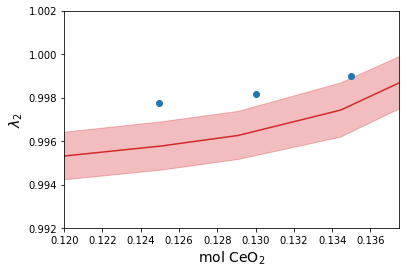

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(cofactors_eddie[:, 0] / 100, cofactors_eddie[:, 1], marker='o', label='Eddie')
ax.plot(
    cof_mean.index,
    cof_mean.B.values,
    color='#d62728',
    label='prediction'
)

ax.fill_between(
    x=cof_mean.index,
    y1=cof_mean.B.values - cof_std.B.values,
    y2=cof_mean.B.values + cof_std.B.values,
    color='#d62728',
    label='prediction',
    alpha=0.3,
    zorder=-1
)

ax.set_ylim(0.992, 1.002)
ax.set_xlim(0.12, 0.1375)

ax.set_ylabel(r'$\lambda_2$', fontsize=14)
ax.set_xlabel(r'mol CeO$_2$', fontsize=14)

plt.show()

In [22]:
cof_std.mean()

T               0.000000
en_p            0.000000
ea              0.000000
valence         0.000000
rad_slater      0.000000
rad_clementi    0.000000
Zr              0.000000
A               0.001119
B               0.001145
C               0.001119
dtype: float64

### Uncertainty in the model's predictions

In [172]:
tetr = tetragonal[
    np.bitwise_and.reduce([
        np.abs(tetragonal['T'] - 25) < 5,
        tetragonal['Ce'] > 0,
        tetragonal['Ce'] + tetragonal['Zr'] == 100
    ])
][['Ce', 'Zr', 'T', 'a', 'c']]

mono = monoclinic[
    np.bitwise_and.reduce([
        np.abs(monoclinic['T'] - 25) < 5,
        monoclinic['Ce'] > 0,
        monoclinic['Ce'] + monoclinic['Zr'] == 100
    ])
][['Ce', 'Zr', 'T', 'a', 'b', 'c', 'beta']]

#### Parameters predicted by the model

In [173]:
inputs = {
    'Ce': tetr['Ce'].values.reshape(-1, 1) / 100,
    'Zr': tetr['Zr'].values.reshape(-1, 1) / 100,
    'T': tetr['T'].values
}
X = featgen.get_features(inputs, model.features)

/miniconda3/envs/dskoda/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [174]:
results = []
for t, _ in model.predict_lattice(X[model.features]):
    results.append(t)
results_df = pd.DataFrame(results)

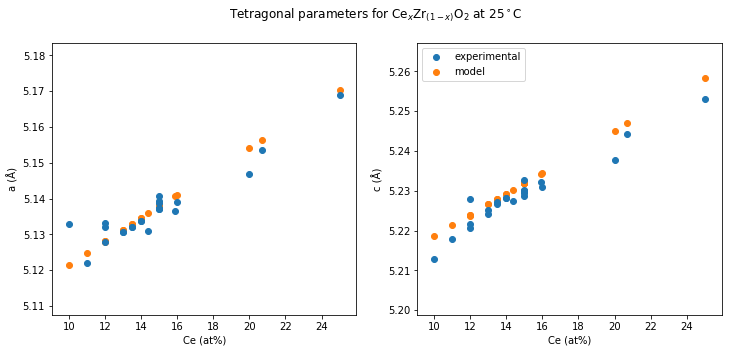

In [180]:
fig, ax_fig = plt.subplots(1, 2, figsize=(12, 5))

df = tetr
for output, ax in zip(['a', 'c'], ax_fig):
    
    ax.scatter(df.Ce, df[output], label='experimental')    
    ax.scatter(df.Ce, results_df[output].values, zorder=-1, label='model')
    
#     rmse, rsq = get_stats(df[output], predict(df.Ce))
    
    ax.set_xlabel('Ce (at%)')
    ax.set_ylabel('%s (Å)' % output)

#     ax.annotate(
#         'RMSE = %.2e \nR$^2$ = %.2f' % (rmse, rsq),
#         (0.05, 0.96),
#         xycoords='axes fraction',
#         va='top',
#         fontsize=12
#     )

plt.legend()
fig.suptitle('Tetragonal parameters for Ce$_x$Zr$_{(1-x)}$O$_2$ at 25$^\circ$C')
plt.show()

#### Monoclinic

In [181]:
inputs = {
    'Ce': mono['Ce'].values.reshape(-1, 1) / 100,
    'Zr': mono['Zr'].values.reshape(-1, 1) / 100,
    'T': mono['T'].values
}
X = featgen.get_features(inputs, model.features)

/miniconda3/envs/dskoda/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [182]:
results = []
for t, m in model.predict_lattice(X[model.features]):
    results.append(m)
results_df = pd.DataFrame(results)

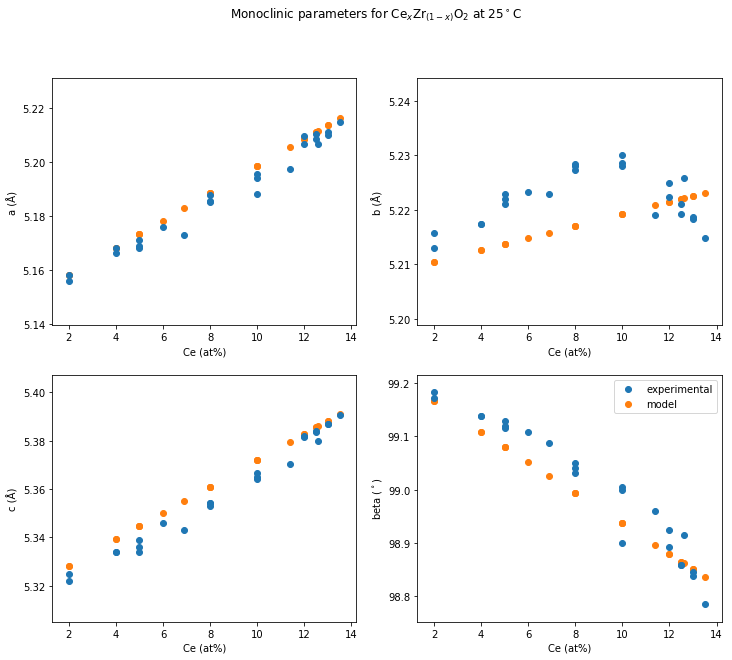

In [186]:
fig, ax_fig = plt.subplots(2, 2, figsize=(12, 10))

df = mono
for output, ax in zip(['a', 'b', 'c', 'beta'], ax_fig.reshape(-1)):    
    unit = '$^\circ$' if output == 'beta' else 'Å'
    
    ax.scatter(df.Ce, df[output], label='experimental')    
    ax.scatter(df.Ce, results_df[output].values, zorder=-1, label='model')
    
#     rmse, rsq = get_stats(df[output], predict(df.Ce))

    ax.set_xlabel('Ce (at%)')
    ax.set_ylabel('%s (%s)' % (output, unit))

#     ax.annotate(
#         'RMSE = %.2e \nR$^2$ = %.2f' % (rmse, rsq),
#         (0.05, 0.96),
#         xycoords='axes fraction',
#         va='top',
#         fontsize=12
#     )

plt.legend()
fig.suptitle('Monoclinic parameters for Ce$_x$Zr$_{(1-x)}$O$_2$ at 25$^\circ$C')
plt.show()